# Fifth order Runge Kutta methods compared

There are many Runge Kutta methods. The main classification is explicit versus implicit. Extensisq only has explicit methods. The second important classification is the order of the method. The classic Runge Kutta method has order 4. In general, higher order methods are suitable for higher accuracies (stricter tolerances). The sweet spot for solving at medium accuracy may be order 5. Such methods are generally recommended at least.

Extensisq has some Runge Kutta methods of order 5 (`BS5`, `Ts5`, `CK5` and `CKdisc`) and these are compared to scipy's fifth order Runge Kutta method 'RK45'. The Lotka-Volterra problem (predator prey model) from the `solve_ivp` page in scipy's reference manual is used for this comparison. The results show that the efficiency of the method depends on the tolerance, even when comparing methods of the same order. It also depends on the problem that is solved, so this is just a demo. Methods may compare be different for other problems.

## Problem definition
The parameters of this problem are defined as additional arguments (`args`) to the derivative function.

In [9]:
def lotkavolterra(t, z, a, b, c, d):
    x, y = z
    return [a*x - b*x*y, -c*y + d*x*y]

problem = {'fun' : lotkavolterra,
            'y0' : [10., 5.],
        't_span' : [0., 15.],
          'args' : (1.5, 1, 3, 1)}

## Reference solution

First, a reference solution is created by solving this problem with low tolerance. A higher order method of Prince is used for this.

In [10]:
from scipy.integrate import solve_ivp
from extensisq import *

reference = solve_ivp(**problem, atol=1e-12, rtol=1e-12, method=Pr7, dense_output=True)

## Solution plot

The prey population grows slowly and decreases rapidly. This is the other way around for the predator population.

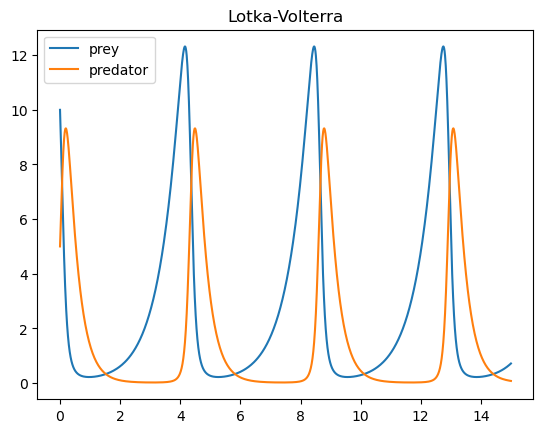

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(reference.t, reference.y.T)
plt.title('Lotka-Volterra')
plt.legend(('prey', 'predator'))
plt.show()

## Efficiency plot

The method is efficient if it can solve problems to low error with low cost. I will use the number of function evaluations as measure of cost. For the error measure I will use the RMS of the error norm over all solution points. A function to calculate it is:

In [12]:
def rms_err_norm(solution, reference=reference):
    error = solution.y - reference.sol(solution.t)
    err_norm = (error**2).mean()**0.5
    return err_norm

Now let's solve this problem with the explicit Runge Kutta method of scipy ('RK45') and those of extensisq (`BS5`, `Ts5`, `CK5` and `CKdisc`) at a few absolute tolerance values and make a plot to compare their efficiency.

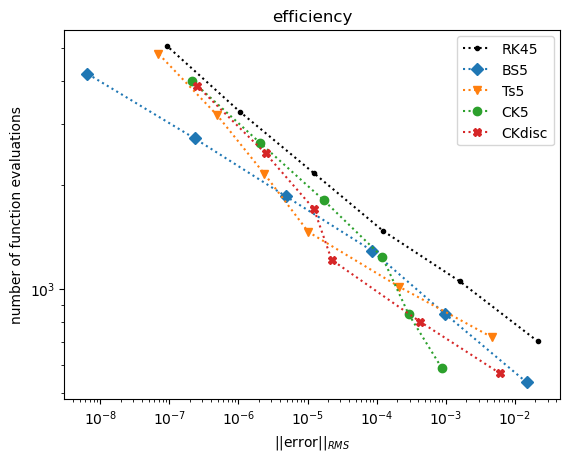

In [13]:
import numpy as np

methods = ['RK45', BS5, Ts5, CK5, CKdisc]
tolerances = np.logspace(-4, -9, 6)

plt.figure()
styles = ['.k:', 'D:', 'v:', 'o:', 'X:']
for method, style in zip(methods, styles):
    name = method if isinstance(method, str) else method.__name__
    e = []
    n = []
    for tol in tolerances:
        sol = solve_ivp(**problem, rtol=1e-13, atol=tol, method=method,
                    dense_output=True)  # To trigger extra evalation in BS5
        assert sol.success, 'solver error'
        err = rms_err_norm(sol)
        e.append(err)
        n.append(sol.nfev)
    plt.loglog(e, n, style, label=name)
plt.legend()
plt.xlabel(r'||error||$_{RMS}$')
plt.ylabel('number of function evaluations')
plt.title('efficiency')
plt.show()     

## Discussion

The highest efficiency is found in the **bottom left corner** of the plot: low error and few function evaluations. The graph shows:
* 'RK45' has the poorest efficiency of all considered methods (for this problem and absolute tolerance values).
* `BS5` has the best efficiency for low (strict) tolerances. Where all other methods seem to approach the same asymptote, `BS5` does not (yet). This look more like 6th order behavior. Notice that dense output was requested. Without it, the number of function evaluations would be even lower. On the other hand, the number would be considerably higher if the best interpolant would have been selected instead of the default one; see the [notebook about `BS5`](Demo_BS5.ipynb).
* `Ts5` is quite similar to 'RK45', but more efficient. It has a sweet spot at atol=1e-6 for this problem. (I don't know why.)
* `CK5` has a relatively good performance at the higher (looser) tolerance values. This may be just luck though.
* `CKdisc` is a variable order method. It's only 5th order if the solution is smooth. It uses lower order embedded methods to solve near discontinuities. Our problem has some features that look discontinuous at coarse time steps, so this solver could benefit. Possibly this is why the highest (loosest) 3 tolerance values result in relatively efficient solutions.

Keep in mind that some of these observations are valid in general, while others are not. Do some experiments on your own problems to see what works best.